# Data exploration

Data exploration of ADNI patients. The data consists of features derived from T1 weighted images of patients in their first MRI visit in each phase of the program. The features were extracted using SIENAX to determine tissue types and FIRST to determine subcortical structure volumes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from scipy.stats import kruskal
from scipy.stats import pearsonr

np.random.seed(0)

### Data merging

In [2]:
def process_df(phase):
    # Load data
    df_features = pd.read_table('../DATA/processed_data_adni%d.tsv'%phase, sep=' ').dropna()
    df_patient_list = pd.read_table('../DATA/participants_adni%d.tsv'%phase, names=['Subject', 'PTID'])
    df_metadata = pd.read_csv('../DATA/adni%d_mri.csv'%phase, index_col=0)
    
    # Combine left and right structures to single structure
    structures = ['Thalmus', 'Caudate', 'Putamen', 'Palidum', 
            'Hippo', 'Amygdala', 'Accumbens']
    for s in structures:
        df_features[s] = df_features['L_%s'%s]+df_features['R_%s'%s]
    
    df_full = df_patient_list.merge(df_features, on='Subject').merge(df_metadata, on='PTID')
                                                                 
    # Remove sites that do not contain alzeihmers patient
    all_sites = set(df_full['SITEID'])
    ad_sites = set(df_full[df_full['DIAGNOSIS']==3.0]['SITEID'])
    missing_sites = [site for site in all_sites if site not in ad_sites]
    df_full = df_full[df_full['SITEID'].isin(missing_sites) == False]
    
    # Get back non-normalized (raw features) and rename
    for f in ['Brain_norm', 'GM_norm', 'WM_norm',
        'vscf_norm', 'pgrey_norm']:
        df_full[f] = df_full[f]/df_full['Vscale']
    df_full.rename(columns={'Brain_norm':'Brain_size', 'GM_norm': 'GM', 
                            'WM_norm':'WM', 'vscf_norm':'vscf', 'pgrey_norm':'pgrey'}, inplace=True)

    # Change gender and phase assigment
    df_full['PTGENDER'].replace(['Female','Male'],[0,1],inplace=True)
    df_full['Phase'].replace(['ADNI2','ADNI3'],[0,1],inplace=True)

    return df_full

# Create dataframes for each phase
df_full_adni2 = process_df(2)
df_full_adni3 = process_df(3)

# Concatenate dataframes
pd.set_option('display.max_columns', None)
df_full = pd.concat([df_full_adni2, df_full_adni3], ignore_index=True)
df_full = df_full.drop_duplicates('RID', keep='first') # keep ADNI2 if duplciates

### Site analysis

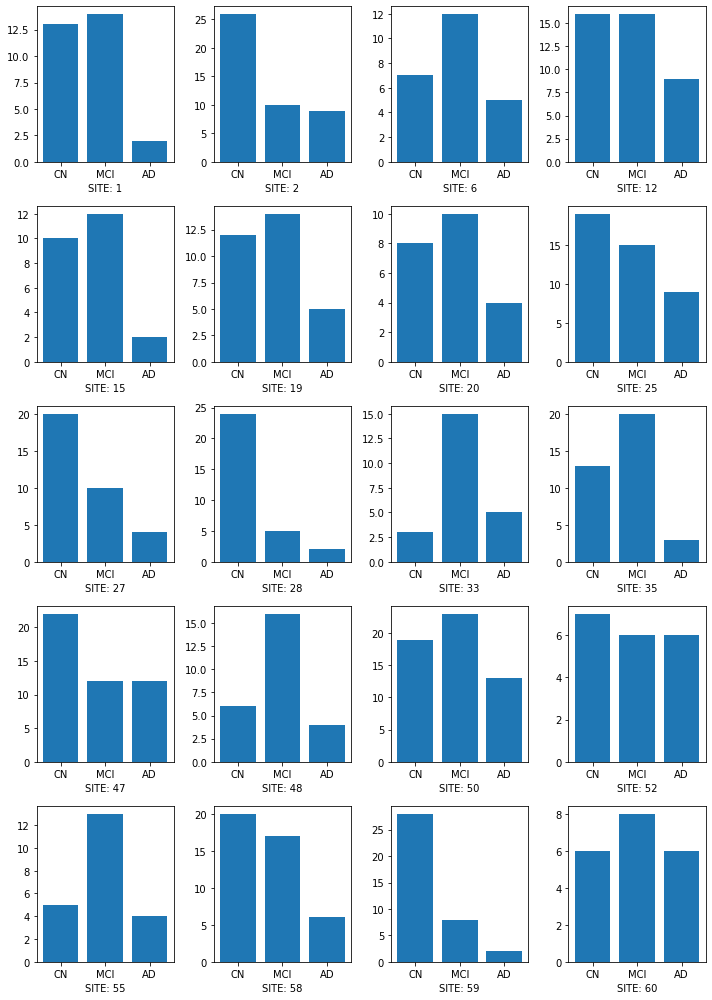

In [3]:
plt.figure(figsize=(10,14))
names = ['CN', 'MCI', 'AD']
sites = set(df_full['SITEID'])
for i, site in enumerate(sites):
    # Explor variability of features by site
    plt.subplot(5,4,i+1)
    df_site = df_full[df_full['SITEID']==site]
    vals = [np.sum(df_site['DIAGNOSIS']==diag) for diag in [1.0, 2.0, 3.0]]
    plt.bar(names, vals)
    plt.xlabel('SITE: %d' %site)
    plt.tight_layout()

Site 33 has too few controls to be able to model site variability effects so we will remove it.

In [4]:
df_full = df_full[df_full['SITEID'].isin([33]) == False]

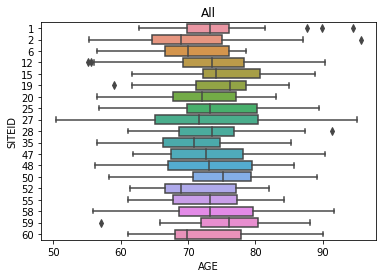

In [5]:
# Show age distribution by site
plt.figure()
plt.title('All')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full, orient='h')
plt.show()

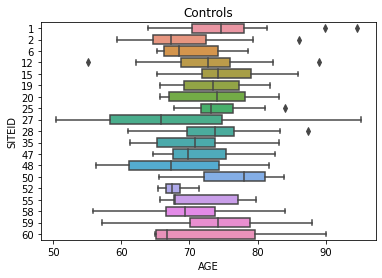

In [6]:
# Show age distribution by site
plt.figure()
plt.title('Controls')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==1.0], orient='h')
plt.show()

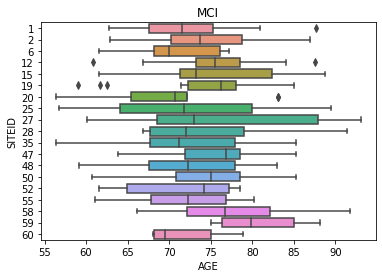

In [7]:
# Show age distribution by site
plt.figure()
plt.title('MCI')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==2.0], orient='h')
plt.show()

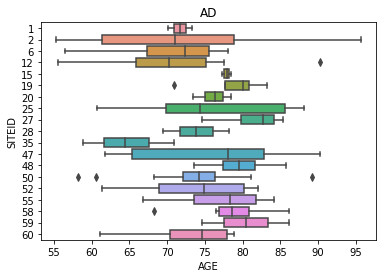

In [8]:
# Show age distribution by site
plt.figure()
plt.title('AD')
ax = sns.boxplot(x='AGE', y='SITEID', data=df_full[df_full['DIAGNOSIS']==3.0], orient='h')
plt.show()

The age distributions are different for each site. However, most importantly is to look at the age distirbutions overall of all the data.

p-value of age distributions
CN vs MCI: 0.012387
CN vs AD: 0.003696
MCI vs AD: 0.299219


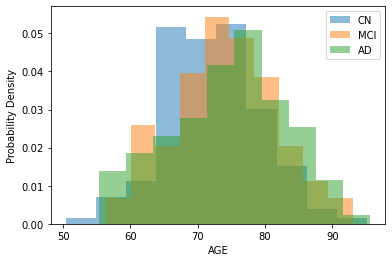

In [9]:
# Check p-values between groups for age
cn_age = df_full[df_full['DIAGNOSIS']==1.0]['AGE'].to_numpy()
mci_age = df_full[df_full['DIAGNOSIS']==2.0]['AGE'].to_numpy()
ad_age = df_full[df_full['DIAGNOSIS']==3.0]['AGE'].to_numpy()

print('p-value of age distributions')
hstat_cnvsmci_age, pval_cnvsmci_age = kruskal(cn_age, mci_age)
hstat_cnvsad_age, pval_cnvsad_age = kruskal(cn_age, ad_age)
hstat_mcivsad_age, pval_mcivsad_age = kruskal(ad_age, mci_age)
print('CN vs MCI: %f' % pval_cnvsmci_age)
print('CN vs AD: %f' % pval_cnvsad_age)
print('MCI vs AD: %f' % pval_mcivsad_age)

plt.hist(cn_age, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

MCI and AD distributions are similar but not with CNs. Hence, we can subsample the controls to obtain a similar age distribution based on the AD distributions which is the most different from CN. We try three different strategies. The first two are based on the fact that the control age distribution is biased with more samples below 75 years old than the other two. The third is based on distribution matchin by subsampling.

In [10]:
def optimize_sampling(sampling_strategy, samples, target_dist, thr_pval, **kwargs):
    for sample_size in range(len(samples), 0, -1):
        new_samples = sampling_strategy(samples, sample_size, **kwargs)
        hstat, pval = kruskal(new_samples, target_dist)
        if pval > thr_pval:
            return new_samples, sample_size

New sample size: 249


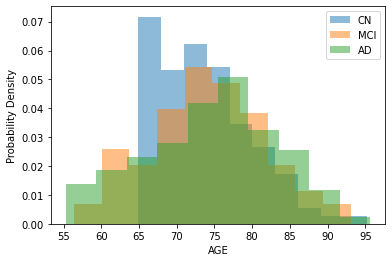

In [11]:
def sort_remove_young(samples, sample_size):
    sorted_samples = np.sort(samples)
    return sorted_samples[len(samples)-sample_size:]

new_samples, sample_size = optimize_sampling(sort_remove_young, cn_age, ad_age, 0.1)

print('New sample size: %d' % sample_size)

plt.hist(new_samples, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Although the null hypothesis will not be rejected by visual inspection the CN distribution looks very different to the rest so rather than just removing the younger ones we can subsample from those below the average of the distribution.

New sample size: 234


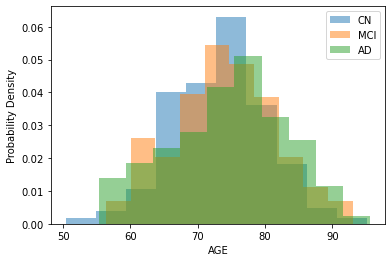

In [12]:
def remove_young_subsampling(samples, sample_size, cutoffage):
    sorted_samples = np.sort(samples)
    cutoff = np.argmax(sorted_samples>cutoffage)
    lower = sorted_samples[:cutoff]
    upper = sorted_samples[cutoff:]
    resampling_size = len(lower)-(len(samples)-sample_size)
    new_lower = np.random.choice(lower, size=resampling_size, replace=False, )
    return  np.concatenate([new_lower, upper])

cutoffage = np.mean(cn_age)
new_samples, sample_size = optimize_sampling(remove_young_subsampling, cn_age, ad_age, 0.1, cutoffage=cutoffage)

print('New sample size: %d' % sample_size)

plt.hist(new_samples, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

The number of samples has been reduced by only 15 more but the shapes now visually look more similar.

New sample size: 204


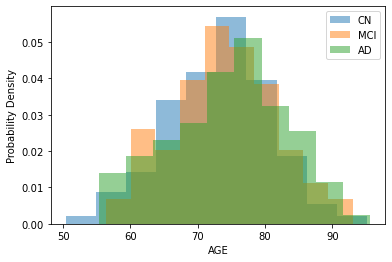

In [13]:
def subsampling_matching(samples, sample_size, subsampling_dist, N_BINS):
    # Obtain `N_BINS` equal frequency bins, in other words percentiles
    step = 100 / N_BINS
    test_percentiles = [
        np.percentile(subsampling_dist, q, axis=0)
        for q in np.arange(start=0, stop=100, step=step)
    ]

    # Match each observation in the training set to a bin
    train_bins = np.digitize(samples, test_percentiles)

    # Count the number of values in each training set bin
    train_bin_counts = np.bincount(train_bins)

    # Weight each observation in the training set based on which bin it is in
    weights = 1 / np.array([train_bin_counts[x] for x in train_bins])

    # Make the weights sum up to 1
    weights_norm = weights / np.sum(weights)

    np.random.seed(0)
    sample = np.random.choice(cn_age, size=sample_size, p=weights_norm, replace=False)
    
    return sample

new_samples, sample_size = optimize_sampling(subsampling_matching, cn_age, ad_age, 0.1,
                                             N_BINS=15, subsampling_dist=ad_age)

print('New sample size: %d' % sample_size)

plt.hist(new_samples, label='CN', density=True, alpha=0.5)
plt.hist(mci_age, label='MCI', density=True, alpha=0.5)
plt.hist(ad_age, label='AD', density=True, alpha=0.5)
plt.xlabel('AGE')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Now the distributions are matched very well but at the cost of removing too many samples. Hence the second strategy will be employed.

In [42]:
df_cn = df_full[df_full['DIAGNOSIS']==1.0]
ages = df_cn['AGE'].to_numpy()
rids = df_cn['RID'].to_numpy()
# Add some small noise so that all the ages are different so that we can match to correct rid later
ages_noise = ages+np.random.normal(0, 0.01, len(ages))
cutoffage = np.mean(ages_noise)
new_samples, sample_size = optimize_sampling(remove_young_subsampling, ages_noise, ad_age, 0.1, cutoffage=cutoffage)
ages_loc = [np.where(age == ages_noise)[0][0] for age in new_samples]
rid_keep = rids[ages_loc]
remove_ids = [rid for rid in rids if not rid in rid_keep]
df_full = df_full[~df_full['RID'].isin(remove_ids)]

### BrainAge Modelling

Create a model that given features extracted from brain images correctly predicts a patients age in control subjects.

In [15]:
# Exctract controls that haven't converted
df_cn = df_full[df_full['TYPECONVERSOR']==1.0]

# Mark features to use
features = ['Brain_size', 'GM', 'WM', 'vscf', 'pgrey', 
        'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']

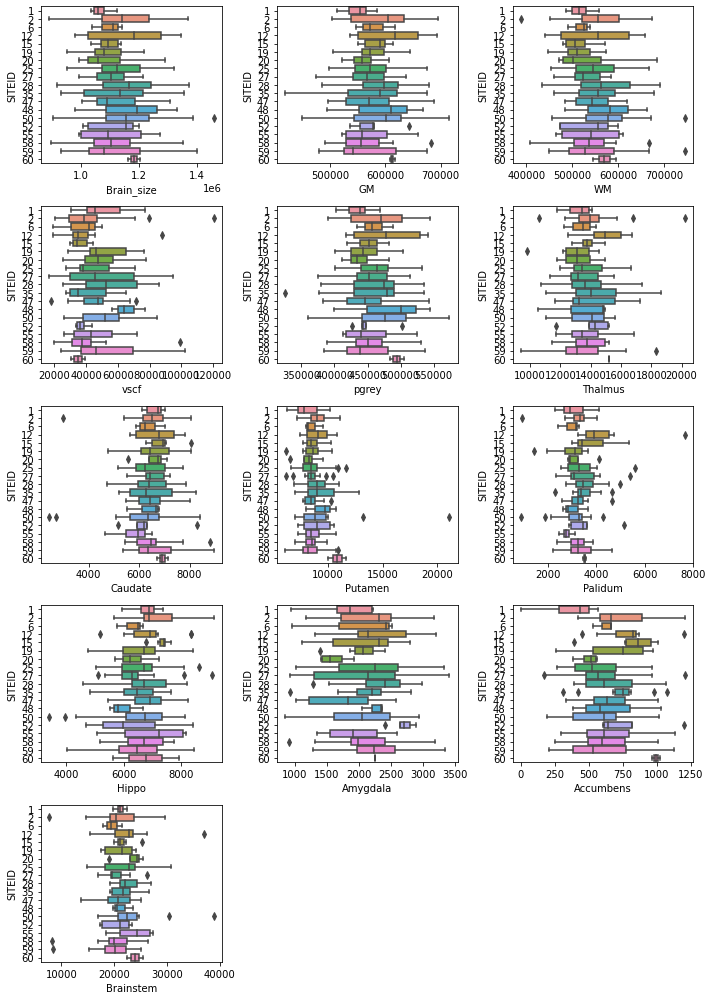

In [16]:
# Explor variability of features by site
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_cn, orient='h')
    plt.tight_layout()

There is great variability in values between each site. So COMBAT can be applied to homogenize data.

In [17]:
# Data harmonization with Combat
from pycombat import Combat
combat = Combat()
Y = df_cn[features].to_numpy()
b = df_cn['SITEID'].to_numpy()
X = df_cn['AGE'].to_numpy()[:, np.newaxis]
C = df_cn[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.fit_transform(Y=Y, b=b, X=X, C=C)

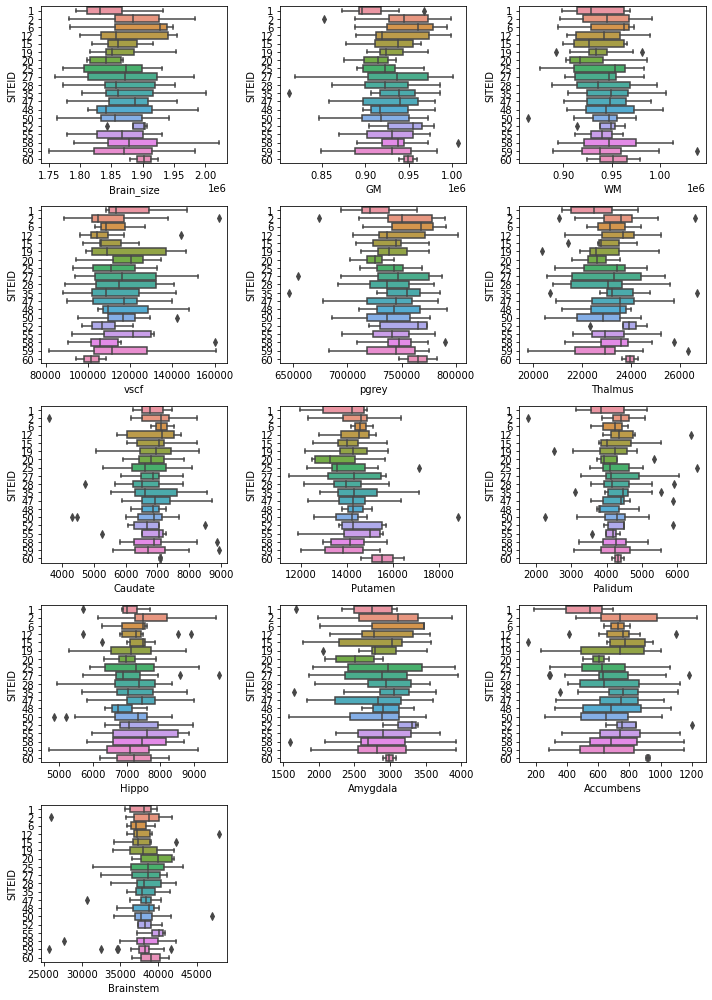

In [18]:
# Explor variability of features by site after harmonization
df_features_harm = pd.DataFrame(data=y_adjusted, columns=features)
df_features_harm['SITEID'] = df_cn['SITEID'].reset_index(drop=True)
plt.figure(figsize=(10,14))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    ax = sns.boxplot(x=feature, y='SITEID', data=df_features_harm, orient='h')
    plt.tight_layout()

Data harmonization does not create perfectly aligned box plots because the dependent variable age has different distributions for each site as previously seen. Age matching was carreid out on the whole cohort and not by site.

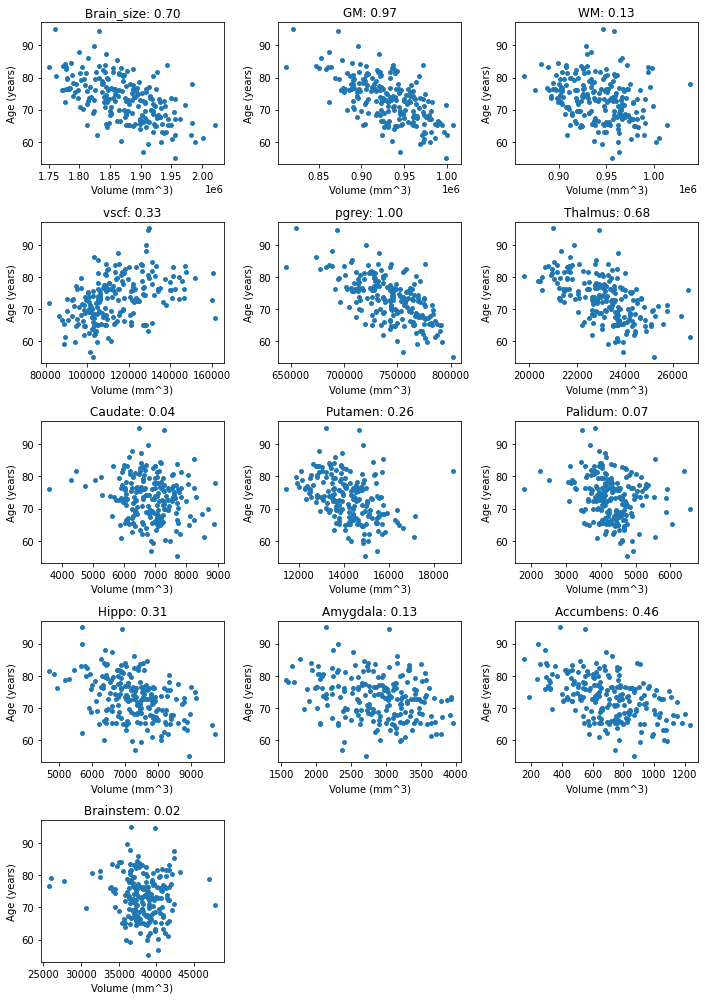

In [19]:
# Explore relationship between each individual feature and age.
X = df_features_harm[features].to_numpy()
Y = df_cn['AGE'].to_numpy()

f_test, _ = f_regression(X, Y)
f_test /= np.max(f_test) # We normalize beacuse we are interested in relative values

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X[:,d],Y,s=15)
    plt.xlabel('Volume (mm^3)')
    plt.ylabel('Age (years)')
    plt.title("{0}: {1:.2f}".format(features[d],f_test[d]))
plt.tight_layout()

There are many features that are clearly linearly related with our dependent variable.

In [20]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

MAE in test: 3.508595


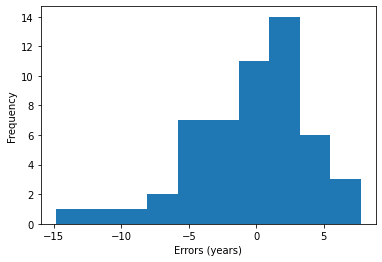

In [21]:
from sklearn.linear_model import LinearRegression

LR_brainage = LinearRegression(fit_intercept='True')
# Train the model
LR_brainage.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test = LR_brainage.predict(X_test_norm)
delta_cn = f_test - Y_test
MAE_test = np.mean(np.abs(delta_cn))
print('MAE in test: %f' % MAE_test)
plt.xlabel('Errors (years)')
plt.ylabel('Frequency')
plt.hist(delta_cn)
plt.show()

A good MAE is achieved with a very simple linear regression model. The best models to estimate have an MAE just below 3. Although they cover a much larger age range usually 5 to 90 instead of 65 to 90. Previous works have already described the linear relationship between brain structures and age for age ranges of 65 to 90. Modelling age is more difficult when mixining both young and old patients. We are only interested for AD pathology in older populations.

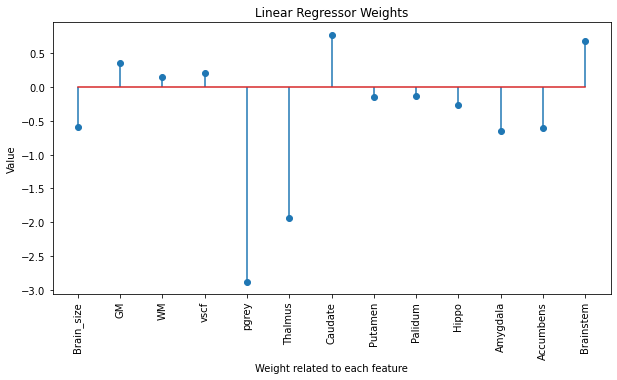

In [22]:
# Linear regressor weights as a measure of importance
LR_weights = LR_brainage.coef_

# Plot weights
plt.figure(figsize=(10,5))
plt.title('Linear Regressor Weights')
plt.stem(features, LR_weights)
plt.xticks(rotation='vertical')
plt.xlabel('Weight related to each feature')
plt.ylabel('Value')
plt.show()

The sign of the weights might not agree with those shown in the correlation analysis because in the correlation analysis we are only taking into account the relationship between the dependendent variable and each variable individiually. Whereas the indepedent variables can be correlated between them and so for example compensate each other since for example pgrey_norm is heavly correlated with GM_norm.

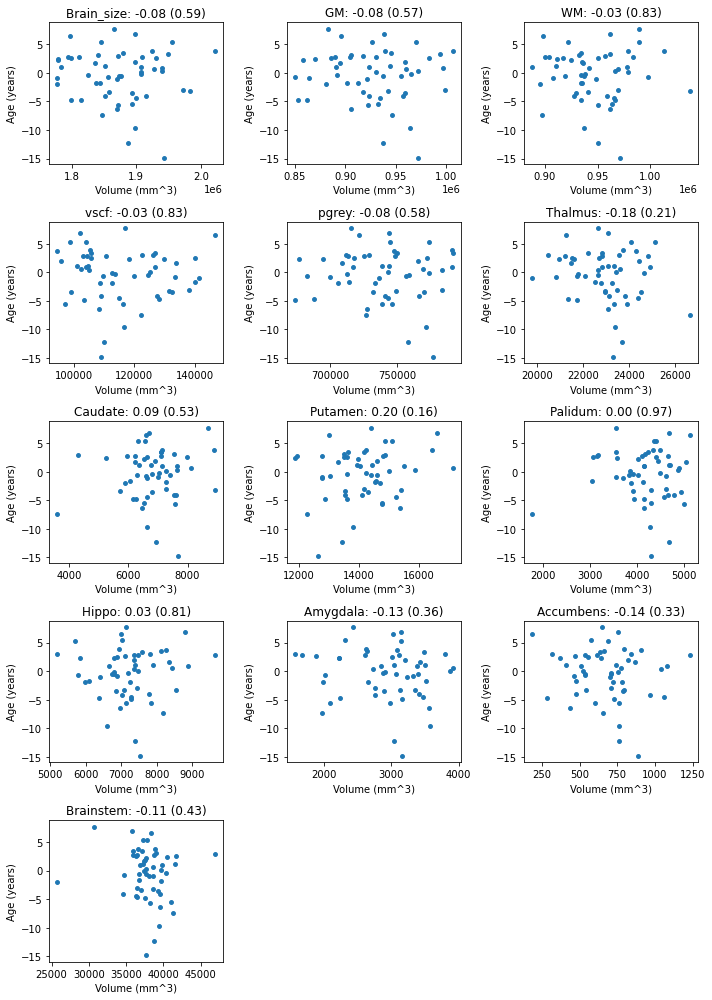

In [23]:
# Explore if there is any correlation between features and delta in controls
f_test, _ = f_regression(X_test, delta_cn)
f_test /= np.max(f_test) # We normalize beacuse we are interested in relative values

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X_test[:,d], delta_cn,s=15)
    plt.xlabel('Volume (mm^3)')
    plt.ylabel('Age (years)')
    pearson_coeff, pval = pearsonr(X_test[:, d], delta_cn)
    plt.title("{0}: {1:.2f} ({2:.2f})".format(features[d],pearson_coeff,pval))
plt.tight_layout()

As expected there is no direct correaltion between brain deltas in controls and the features.

In [24]:
# Performance evaluation of Ridge Regressor with Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Variables
alpha_values_ridge = np.logspace(-2, 3, num=30)
tuned_parameters_ridge = [{'alpha': alpha_values_ridge}]
nfold = 5

# Create pipeline (Creatue poly features, normalize features, use these to train model)
steps = [('poly', PolynomialFeatures()), ('normalize', StandardScaler()), ('clf', Ridge())]
pipe_Ridge = Pipeline(steps)

# Do not include a bias term when creating features
pipe_Ridge.set_params(poly__include_bias=False)
# Make sure the bias is fit
pipe_Ridge.set_params(clf__fit_intercept=True)

# CV range of values to check
param_grid_Ridge = dict(poly__degree=[1, 2, 3], clf__alpha = alpha_values_ridge)

# Create CV grid search
pipe_grid_search_Ridge = GridSearchCV(pipe_Ridge, param_grid=param_grid_Ridge, cv=nfold, scoring='neg_mean_squared_error')
# No need to feed normalized data as it will be normalized in the pipeline
pipe_grid_search_Ridge.fit(X_train, Y_train)

# Optimum hyperparameter values
PolyRidge_degree_opt = pipe_grid_search_Ridge.best_params_['poly__degree']
print('Optimum value of polynomial degree is %d' % PolyRidge_degree_opt)
PolyRidge_alpha_opt = pipe_grid_search_Ridge.best_params_['clf__alpha']
print('Optimum value of alpha is %.2f' % PolyRidge_alpha_opt)

# Compute the predictions over train and test data
PolyRidge_f_train = pipe_grid_search_Ridge.predict(X_train)
PolyRidge_f_test = pipe_grid_search_Ridge.predict(X_test)

# Calculate MSE for both train and test
PolyRidge_MAE_train = metrics.mean_absolute_error(Y_train, PolyRidge_f_train)
PolyRidge_MAE_test = metrics.mean_absolute_error(Y_test, PolyRidge_f_test)

# Show result
print("The trained Ridge regressor with polynomial features has an MSE for the training data of: %.2f" % PolyRidge_MAE_train)
print("The trained Ridge regressor with polynomial features has an MSE for the test data of: %.2f" % PolyRidge_MAE_test)

Optimum value of polynomial degree is 1
Optimum value of alpha is 62.10
The trained Ridge regressor with polynomial features has an MSE for the training data of: 3.96
The trained Ridge regressor with polynomial features has an MSE for the test data of: 3.44


In [25]:
# Performance evaluation of weighted KNN
from sklearn.neighbors import KNeighborsRegressor

# Define tuned_parameters
rang_K = range(1, 21)
tuned_parameters_kNN  = dict(kNN__n_neighbors = rang_K)

# Create pipeline and ensure neighbours are weighted by the inverse of their distance
pipe_WkNN = Pipeline([('scaler', StandardScaler()), ('kNN', KNeighborsRegressor(weights='distance'))])

# Create a gridSearch over the pipeline
pipe_grid_search_WkNN = GridSearchCV(pipe_WkNN, tuned_parameters_kNN, cv=nfold, scoring='neg_mean_squared_error')

# Train
pipe_grid_search_WkNN.fit(X_train, Y_train)

# Optimum hyperparameter values
Weighted_KNN_neighbors_opt = pipe_grid_search_WkNN.best_params_['kNN__n_neighbors']
print('Optimum value of neighbors is %d' %Weighted_KNN_neighbors_opt)


# Compute the predictions over train and test data
Weighted_KNN_f_train = pipe_grid_search_WkNN.predict(X_train)
Weighted_KNN_f_test = pipe_grid_search_WkNN.predict(X_test)

# Calculate MSE for both train and test
Weighted_KNN_MAE_train = metrics.mean_absolute_error(Y_train, Weighted_KNN_f_train)
Weighted_KNN_MAE_test = metrics.mean_absolute_error(Y_test, Weighted_KNN_f_test)

# Show result
print("The trained kNN has an MSE for the training data of: %.2f" % Weighted_KNN_MAE_train)
print("The trained kNN has an MSE for the test data of: %.2f" % Weighted_KNN_MAE_test)

Optimum value of neighbors is 11
The trained kNN has an MSE for the training data of: 0.00
The trained kNN has an MSE for the test data of: 3.85


In [26]:
# Generate Sklearn Gradient Boosting Classifier
import xgboost as xgb
xgbR= xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=7,
                       subsample=0.1, learning_rate=0.1)
    
# Train
xgbR.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test_xgbr = xgbR.predict(X_test_norm)
errors_xgbr = Y_test-f_test_xgbr
MAE_test_xgbr = np.mean(np.abs(errors_xgbr))
print('MAE in test: %f' % MAE_test_xgbr)

/Users/jorgegarciacondado/opt/anaconda3/envs/adni/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


MAE in test: 3.981694


No real improvement in any of the more complex models so following occam's razor the linear regressor is the best to follow for further analysis.

There is a bias in the model as younger controls tend to be given higher ages than they have and older patients are given an younger ages than they have. It can be thought of in terms of our best estimate for a subject which we know nothing is the median so younger patients would be given older ages and older patients lower ages (A.G. de Lange & J. H. Cole 2020)

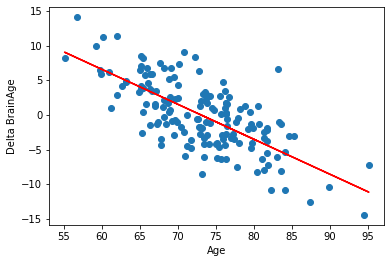

In [27]:
# Explore relationship between age and delta
f_train = LR_brainage.predict(X_train_norm)
delta_train = f_train - Y_train
LR_age_bias = LinearRegression(fit_intercept='True')
LR_age_bias.fit(Y_train.reshape(-1, 1), f_train)
bias_correction = LR_age_bias.predict(Y_train.reshape(-1, 1))
plt.scatter(Y_train, delta_train)
plt.plot(Y_train, np.mean(bias_correction) - bias_correction, c='r')
plt.ylabel('Delta BrainAge')
plt.xlabel('Age')
plt.show()

However, this can be fixed by adjusting the predicted BrainAge taking into account the actual age of the patient to correct for this bias, as shown below:

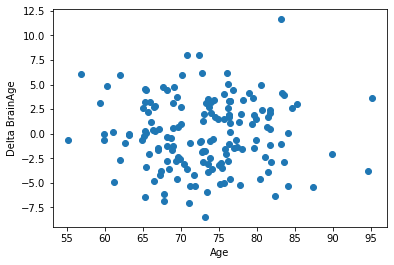

In [28]:
f_train_no_bias = f_train + (Y_train-LR_age_bias.predict(Y_train.reshape(-1, 1)))
plt.scatter(Y_train, f_train_no_bias-Y_train)
plt.ylabel('Delta BrainAge')
plt.xlabel('Age')
plt.show()

MAE in test: 2.909670


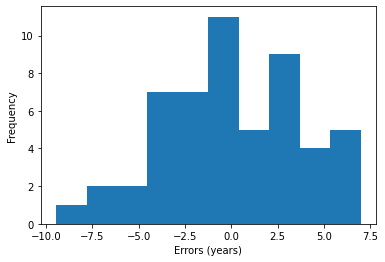

In [29]:
# Compute the predictions over test data with bias correction
f_test = LR_brainage.predict(X_test_norm)
f_test_no_bias = f_test + (Y_test-LR_age_bias.predict(Y_test.reshape(-1, 1)))
delta_cn = f_test_no_bias - Y_test
MAE_test = np.mean(np.abs(delta_cn))
print('MAE in test: %f' % MAE_test)
plt.xlabel('Errors (years)')
plt.ylabel('Frequency')
plt.hist(delta_cn)
plt.show()

There is an improvment of 0.6 in the MAE

### Analysis of brain deltas

An exploration of the difference between the predicted age by the model and the real age of participants, which we call the brain delta. The model is trained on healthy controls so we expect that MCI and AD patients might have significantly different deltas.

In [30]:
# Harmonize all data
Y = df_full[features].to_numpy()
b = df_full['SITEID'].to_numpy()
X = df_full['AGE'].to_numpy()[:, np.newaxis]
C = df_full[['Vscale', 'PTGENDER', 'Phase']].to_numpy()
y_adjusted = combat.transform(Y=Y, b=b, X=X, C=C)
X_norm = transformer.transform(y_adjusted)
age = df_full['AGE'].to_numpy()
df_full['PredBrainAge'] = LR_brainage.predict(X_norm) + (age-LR_age_bias.predict(age.reshape(-1,1)))
df_full['BrainDelta'] = df_full['PredBrainAge']-df_full['AGE']

In [31]:
# Cohen's d size: 0.01 Very small, 0.2 Small, 0.5 Medium, 0.8 Large, 1.2 Very large, 2.0 Huge
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

Brain delta mean for
CN: 0.063712
MCI: 3.211299
AD: 7.711423
Brain delta median for
CN: -0.054487
MCI: 2.979304
AD: 7.561053
p-value
CN vs MCI: 0.000142
CN vs AD: 0.000142
MCI vs AD: 0.000000
Cohens d
CN vs MCI: -0.635011
CN vs AD: -1.419104
MCI vs AD: 0.711943


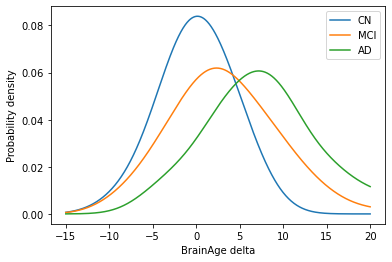

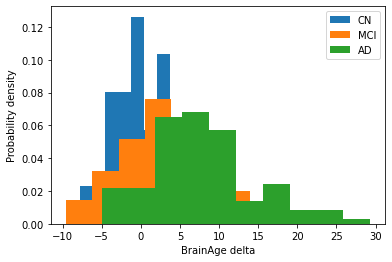

In [32]:
# Explore difference between CN, MCI and AD deltas
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Make estimations
delta_mci = df_mci['BrainDelta'].to_numpy()
delta_ad = df_ad['BrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_cn))
print('MCI: %f' % np.mean(delta_mci))
print('AD: %f' % np.mean(delta_ad))
print('Brain delta median for')
print('CN: %f' % np.median(delta_cn))
print('MCI: %f' % np.median(delta_mci))
print('AD: %f' % np.median(delta_ad))

# Calculate p-value
print('p-value')
hstat_cnvsmci, pval_cnvsmci = kruskal(delta_cn, delta_mci)
hstat_cnvsad, pval_cnvsad = kruskal(delta_cn, delta_mci)
hstat_mcivsad, pval_mcivsad = kruskal(delta_ad, delta_mci)
print('CN vs MCI: %f' % pval_cnvsmci)
print('CN vs AD: %f' % pval_cnvsad)
print('MCI vs AD: %f' % pval_mcivsad)

# Calculate cohen's d size
print('Cohens d')
cohend_cnvsmci = cohen_d(delta_cn, delta_mci)
cohend_cnvsad = cohen_d(delta_cn, delta_ad)
cohend_mcivsad = cohen_d(delta_ad, delta_mci)
print('CN vs MCI: %f' % cohend_cnvsmci)
print('CN vs AD: %f' % cohend_cnvsad)
print('MCI vs AD: %f' % cohend_mcivsad)

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.xlabel('BrainAge delta')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_cn, label='CN', density=True)
plt.hist(delta_mci, label='MCI', density=True)
plt.hist(delta_ad, label='AD', density=True)
plt.xlabel('BrainAge delta')
plt.ylabel('Probability density')
plt.legend()
plt.show()

There is clearly a difference in brain age deltas between CN, MCI and AD as already previously shown in other publications.

### Analysis of conversors

Analyse the value of brain delta as a biomarker for conversors. That is either CN that progress to MCI and also MCI that progress to AD.

p-value of age distributions
CN vs CN2MCI: 0.829705
Brain delta mean for
CN: 0.063712
CN2MCI: 3.676165
Brain delta median for
CN: -0.054487
CN2MCI: 3.776187
p-value
CN vs CN2MCI: 0.003491
Cohens d
CN vs CN2MCI: -0.789408


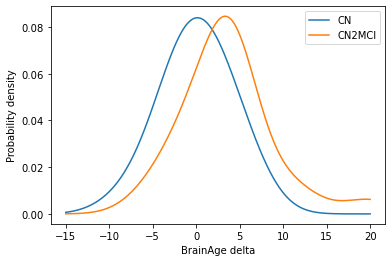

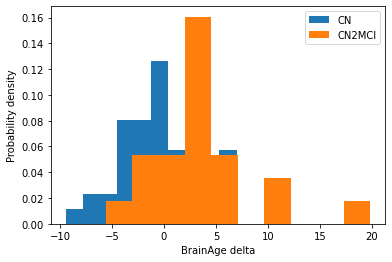

In [33]:
# Explore differences between CN and CN2MCI conversors
df_cn2mci = df_full[df_full['TYPECONVERSOR']==4.0]
delta_cn2mci = df_cn2mci['BrainDelta'].to_numpy()

# Check p-values between groups for age not different
mci_age_noconv = df_cn['AGE'].to_numpy()
mci_age_conv = df_cn2mci['AGE'].to_numpy()
print('p-value of age distributions')
hstat_noconvvsconv_age, pval_noconvvsconv_age = kruskal(mci_age_noconv, mci_age_conv)
print('CN vs CN2MCI: %f' % pval_noconvvsconv_age)

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_cn))
print('CN2MCI: %f' % np.mean(delta_cn2mci))
print('Brain delta median for')
print('CN: %f' % np.median(delta_cn))
print('CN2MCI: %f' % np.median(delta_cn2mci))

# Calculate p-value
print('p-value')
hstat_cn2mci, pval_cn2mci = kruskal(delta_cn, delta_cn2mci)
print('CN vs CN2MCI: %f' % pval_cn2mci)

# Calculate cohen's d size
print('Cohens d')
cohend_cn2mci = cohen_d(delta_cn, delta_cn2mci)
print('CN vs CN2MCI: %f' % cohend_cn2mci)

# Plot kernel densities
kde_cn = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn2mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='CN2MCI')
plt.xlabel('BrainAge delta')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_cn, label='CN', density=True)
plt.hist(delta_cn2mci, label='CN2MCI', density=True)
plt.xlabel('BrainAge delta')
plt.ylabel('Probability density')
plt.legend()
plt.show()

There is a clear difference in brain age deltas between CN that do not convert to MCI and those that do.

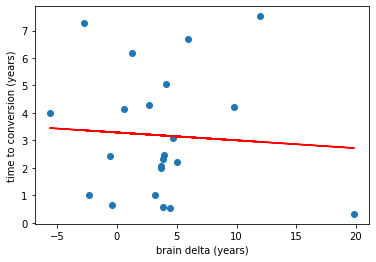

Model metrics:
R^2: 0.004492
Pearson coeff (p-value): -0.067020 (0.766973)


In [34]:
# Explore relationship between conversion time and brain delta for CN2MCI
df_cn2mci = df_cn2mci.copy()
df_cn2mci['TIME2CONVERSION'] = df_cn2mci['CONVERSIONDATE'].astype('datetime64') \
                               - df_cn2mci['SCANDATE'].astype('datetime64')
times = df_cn2mci['TIME2CONVERSION'].to_numpy()/pd.to_timedelta(1, unit='D')/365

# Plot linear regression
LR_cn2mci = LinearRegression()
LR_cn2mci.fit(delta_cn2mci.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_cn2mci.predict(delta_cn2mci.reshape(-1, 1))
 
# predicted values
plt.plot(delta_cn2mci, predicted_times, color='r')
plt.scatter(delta_cn2mci, times)
plt.xlabel('brain delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, delta_cn2mci)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

A good biomarker should show that with increased value the conversion time should be smaller. There is no statistically significant relationship between brain deltas and time to conversion from CN to MCI.

p-value of age distributions
MCI vs MCI2AD: 0.168313
Brain delta mean for
MCI: 2.158507
MCI2AD: 6.172318
Brain delta median for
MCI: 2.240941
MCI2AD: 6.249475
p-value
MCI vs MCI2AD: 0.000011
Cohens d
MCI vs MCI2AD: -0.684467


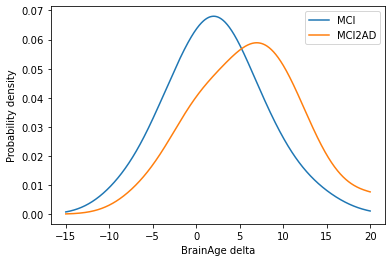

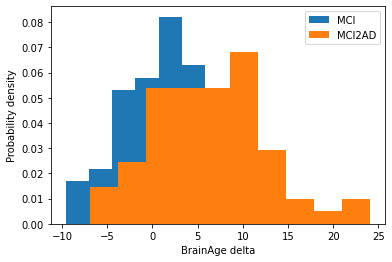

In [35]:
# Explore differences between MCI and CN2MCI conversors
df_mci = df_full[df_full['TYPECONVERSOR']==2.0]
df_mci2ad = df_full[df_full['TYPECONVERSOR']==5.0]
delta_mci2ad = df_mci2ad['BrainDelta'].to_numpy()
delta_mci = df_mci['BrainDelta'].to_numpy()

# Check p-values between groups for age not different
mci_age_noconv = df_mci['AGE'].to_numpy()
mci_age_conv = df_mci2ad['AGE'].to_numpy()
print('p-value of age distributions')
hstat_noconvvsconv_age, pval_noconvvsconv_age = kruskal(mci_age_noconv, mci_age_conv)
print('MCI vs MCI2AD: %f' % pval_noconvvsconv_age)

# Obtain mean and medians for each
print('Brain delta mean for')
print('MCI: %f' % np.mean(delta_mci))
print('MCI2AD: %f' % np.mean(delta_mci2ad))
print('Brain delta median for')
print('MCI: %f' % np.median(delta_mci))
print('MCI2AD: %f' % np.median(delta_mci2ad))

# Calculate t-test
print('p-value')
hstat_mci2ad, pval_mci2ad = kruskal(delta_mci, delta_mci2ad)
print('MCI vs MCI2AD: %f' % pval_mci2ad)

# Calculate cohen's d size
print('Cohens d')
cohend_mci2ad = cohen_d(delta_mci, delta_mci2ad)
print('MCI vs MCI2AD: %f' % cohend_mci2ad)

# Plot kernel density estimates
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci2ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
plt.xlabel('BrainAge delta')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histograms
plt.hist(delta_mci, label='MCI', density=True)
plt.hist(delta_mci2ad, label='MCI2AD', density=True)
plt.xlabel('BrainAge delta')
plt.ylabel('Probability density')
plt.legend()
plt.show()

There is statistically significant difference between MCI and MCI2AD conversros in terms of their brain age deltas.

In [36]:
total_mci = len(df_full[df_full['DIAGNOSIS']==2.0])
mci_noconv = len(df_full[df_full['TYPECONVERSOR']==2.0])
mci_conv = len(df_full[df_full['TYPECONVERSOR']==5.0])
mci_reverse = len(df_full[df_full['TYPECONVERSOR']==7.0])
print('Percentage of patient types:')
print('MCI -> MCI: %f' % (mci_noconv/total_mci))
print('MCI -> AD: %f' % (mci_conv/total_mci))
print('MCI -> CN: %f' % (mci_reverse/total_mci))

Percentage of patient types:
MCI -> MCI: 0.668050
MCI -> AD: 0.273859
MCI -> CN: 0.058091


The percentage of patients converting to AD is similar to those previously reported in other studies which range from 15% to 25%.

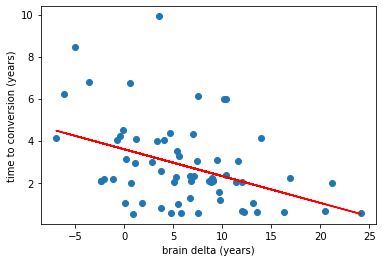

Model metrics:
R^2: 0.166457
Pearson coeff (p-value): -0.407992 (0.000673)


In [37]:
# Explore relationship between conversion time and brain delta for MCI2AD
df_mci2ad = df_mci2ad .copy()
df_mci2ad['TIME2CONVERSION'] = df_mci2ad['CONVERSIONDATE'].astype('datetime64') \
                               - df_mci2ad['SCANDATE'].astype('datetime64')
times = df_mci2ad['TIME2CONVERSION'].to_numpy()/pd.to_timedelta(1, unit='D')/365

# Plot linear regression
LR_mci2ad = LinearRegression()
LR_mci2ad.fit(delta_mci2ad.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_mci2ad.predict(delta_mci2ad.reshape(-1, 1))
 
# predicted values
plt.plot(delta_mci2ad, predicted_times, color='r')
plt.scatter(delta_mci2ad, times)
plt.xlabel('brain delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, delta_mci2ad)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

There seems to be a good correlation between brain age deltas and the time taken to convert from MCI to AD. This comes to show that brain age deltas are a good biomarker candidate for conversion from MCI to AD.

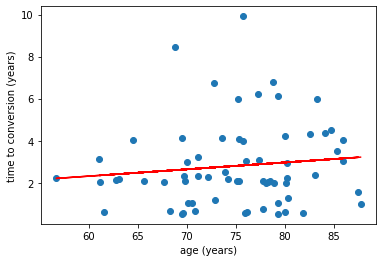

Model metrics:
R^2: 0.013045
Pearson coeff (p-value): 0.114214 (0.361166)


In [38]:
# Explore relationship between conversion time and age
ages_mci2ad = df_mci2ad['AGE'].to_numpy()
LR_mci2ad = LinearRegression()
LR_mci2ad.fit(ages_mci2ad.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_mci2ad.predict(ages_mci2ad.reshape(-1, 1))
 
# predicted values
plt.plot(ages_mci2ad, predicted_times, color='r')
plt.scatter(ages_mci2ad, times)
plt.xlabel('age (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, ages_mci2ad)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

The time to conversion for MCI2AD patients does not seem to be correlated with age, i.e. older patients don't convert faster than younger ones.

In [39]:
# Explore relationship between features and conversors and non-conversors
features_mci = df_mci[features].to_numpy()
features_mci2ad = df_mci2ad[features].to_numpy()
bonferroni_corrected_val = 0.05/len(features)
print('p-value MCI vs MCI2AD (<%f)'%bonferroni_corrected_val)
significant_features = []
for d in range(len(features)):
    hstat_mci2ad, pval_mci2ad = kruskal(features_mci[:, d], features_mci2ad[:, d])
    print('%s: %f' % (features[d], pval_mci2ad))
    if pval_mci2ad < bonferroni_corrected_val:
        significant_features.append(d)

p-value MCI vs MCI2AD (<0.003846)
Brain_size: 0.119788
GM: 0.003551
WM: 0.943224
vscf: 0.345356
pgrey: 0.001203
Thalmus: 0.124628
Caudate: 0.844728
Putamen: 0.010757
Palidum: 0.811777
Hippo: 0.000019
Amygdala: 0.242190
Accumbens: 0.015179
Brainstem: 0.339698


There are several features (GM, pgrey and Hippo) that are good indicators of wether a patient is a conversor or not.

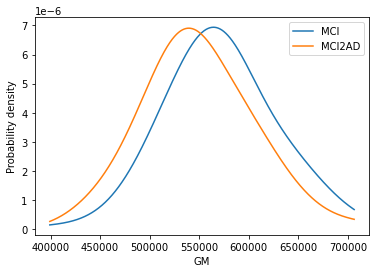

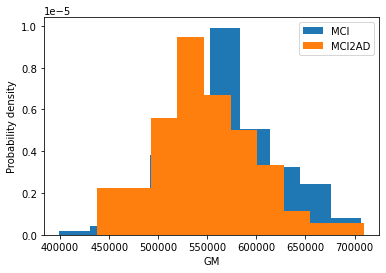

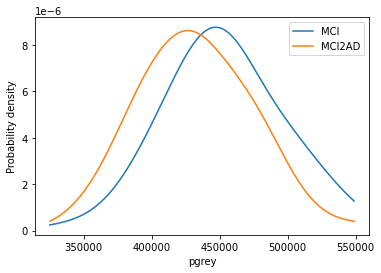

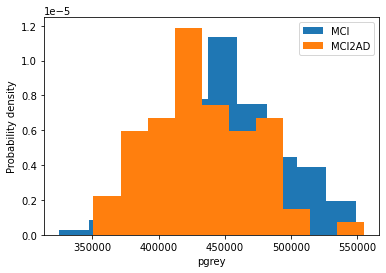

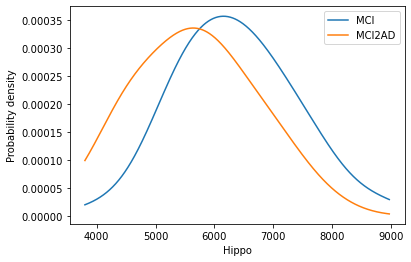

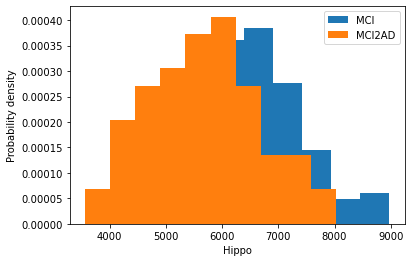

In [40]:
for f in significant_features:
    min_val, max_val = np.min(features_mci[:, f]), np.max(features_mci[:, f])
    range_vals = max_val - min_val
    X_plot = np.linspace(min_val, max_val, 1000)[:, np.newaxis]
    # Plot kernel density estimates
    kde_mci = KernelDensity(kernel="gaussian", bandwidth=range_vals/10).fit(features_mci[:, f].reshape(-1, 1))
    log_dens_mci = kde_mci.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
    kde_ad = KernelDensity(kernel="gaussian", bandwidth=range_vals/10).fit(features_mci2ad[:, f].reshape(-1, 1))
    log_dens_ad = kde_ad.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
    plt.xlabel(features[f])
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()
    # Plot histograms
    plt.hist(features_mci[:, f], label='MCI', density=True)
    plt.hist(features_mci2ad[:, f], label='MCI2AD', density=True)
    plt.xlabel(features[f])
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

Several papers already showed Hippocampus as a biomarker for conversion.

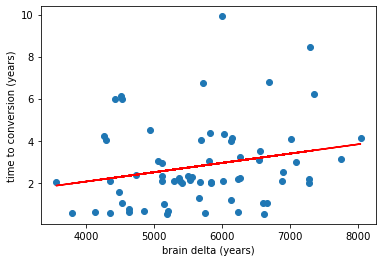

Model metrics:
R^2: 0.050050
Pearson coeff (p-value): 0.223719 (0.070959)


In [41]:
# Explore relationship between hippo size and time to conversion
hippo = features_mci2ad[:, significant_features[2]]
LR_mci2ad = LinearRegression()
LR_mci2ad.fit(hippo.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_mci2ad.predict(hippo.reshape(-1, 1))
 
# predicted values
plt.plot(hippo, predicted_times, color='r')
plt.scatter(hippo, times)
plt.xlabel('brain delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, hippo)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

The hippocampus size can be a good indicator conversion but is not as powerful to tell when it will happen compared to BrainAge delta.